# Evaluation of experiment

Evaluates the results that come from one experiment

To reproduce run experiments/experiment_2_frequency/hpc_training.sh

## Experiment 2 Frequency

In [1]:
# specify EXPERIMENT_NAME - has to correspond to experiments/EXPERIMENT_NAME and models/EXPERIMENT_NAME
experiment_name = "experiment_2_frequency"

In [2]:
#change cwd but save path to notebook to save figures
import os
if not 'src' in os.listdir():
    base_dir_notebook = os.path.abspath(".")
    os.chdir("../..")
import pandas as pd
import yaml
import numpy as np
from src.models.utils import load_model, get_best_model_path, get_loss, TrainedModels
from torch.utils.data import DataLoader
from src.data.synthetic_dataset import SyntheticDataset
from scipy.stats import wilcoxon
import pytorch_lightning as pl
import seaborn as sns
import matplotlib.pyplot as plt
from src.visualization.visualize import TrainValidationLossVisualization, Visualization, InferenceTimeVisualization
import optuna
from src.visualization.utils import FAU_BLUE, FAU_GREY, TURQUOIS
import matplotlib.patches as patches

model_names = ["Transformer", "CNN", "LSTM"]
palette = [FAU_BLUE, FAU_GREY, TURQUOIS] # color palette for seaborn
palette_bp = [(98/256, 114/256, 136/256), FAU_GREY, TURQUOIS] # better color palette for boxplots

models_path = f"models/{experiment_name}"
test_dataset_path = f"./experiments/{experiment_name}/data/test.pkl"

trained_models = TrainedModels(models_path=models_path)

# figure path
if not os.path.exists(f"./experiments/{experiment_name}/figures"):
    os.makedirs(f"./experiments/{experiment_name}/figures")


2021-11-11 00:10:45 Mischa-PC src.models[1380] INFO Initializing Lightning model without test dataset
2021-11-11 00:10:45 Mischa-PC src.data[1380] INFO Loading dataset from ./experiments/experiment_2_frequency/data/train.pkl
2021-11-11 00:10:45 Mischa-PC src.data[1380] INFO Loading dataset from ./experiments/experiment_2_frequency/data/val.pkl
2021-11-11 00:10:45 Mischa-PC src.data[1380] INFO Shuffling dataset
2021-11-11 00:10:45 Mischa-PC src.data[1380] INFO Initializing and fitting new scaler to dataset
2021-11-11 00:10:45 Mischa-PC src.data[1380] INFO Using provided scaler to normalize dataset
2021-11-11 00:10:47 Mischa-PC src.models[1380] INFO Training size: 9984, Validation size: 1920
2021-11-11 00:10:47 Mischa-PC src.models[1380] INFO Transformer complexity: 805306368
2021-11-11 00:10:47 Mischa-PC src.models[1380] INFO Provided path successfully loaded Model of type: <class 'src.models.lightning_models.Transformer'>
2021-11-11 00:10:47 Mischa-PC src.models[1380] INFO Initializing

# Visualize train/validation loss

2021-11-11 00:10:47 Mischa-PC src.visualization[1380] INFO using latex font


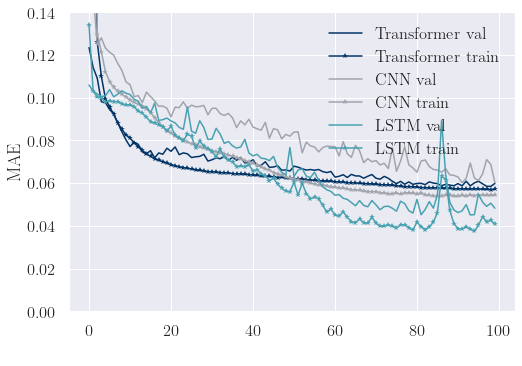

In [3]:
#load val/train loss
epoch = []
values = []
for model in trained_models:
    epoch.append(np.arange(len(model["val_loss"])))
    epoch.append(np.arange(len(model["train_loss"])))
    values.append(model["val_loss"])
    values.append(model["train_loss"])

# prepare style of plot
linestyle = ["-", "-","-", "-","-", "-",]
labels = ["Transformer val", "Transformer train", "CNN val", "CNN train", "LSTM val", "LSTM train"]
markers = ["", "*", "", "*", "", "*"]

# plot train and validaton loss and save figure
viz = TrainValidationLossVisualization(use_latex_font=True, font_scale=1.5)
viz.subplots(1, 1)
viz.plot(steps=epoch, val_losses=values, labels=labels, linestyles=linestyle, markers=markers, xlabel="Epochs", ylabel="MAE")
plt.xlabel("EpochsOl", color='#ffffff')
plt.legend()
plt.grid()
plt.ylim(0, 0.14)
plt.savefig(f"{base_dir_notebook}/figures/train_and_val_loss_all_models.pdf")
plt.show()

# Validation Loss only

2021-11-11 00:10:52 Mischa-PC src.visualization[1380] INFO using latex font


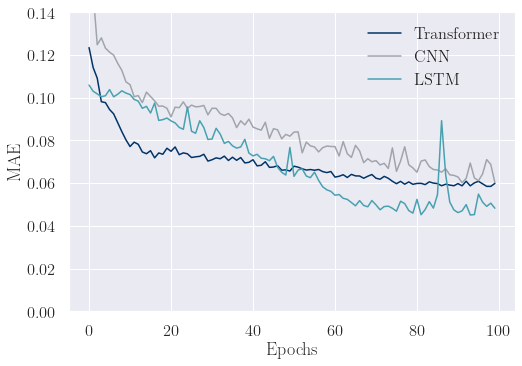

In [4]:
epoch = []
values = []
for model in trained_models:
    epoch.append(np.arange(len(model["val_loss"])))
    values.append(model["val_loss"])

linestyle = ["-","-","-"]
labels = ["Transformer", "CNN", "LSTM"]
markers = ["", "", ""]
colors = [FAU_BLUE, FAU_GREY, TURQUOIS]

# plot train and validaton loss and save figure
viz = TrainValidationLossVisualization(use_latex_font=True, font_scale=1.5)
viz.subplots(1, 1)
viz.plot(steps=epoch, val_losses=values, labels=labels, linestyles=linestyle, markers=markers, colors=colors, xlabel="Epochs", ylabel="MAE")
plt.legend()
plt.grid()
plt.ylim(0, 0.14)
plt.savefig(f"{base_dir_notebook}/figures/validation_loss_all_models.pdf")
plt.show()

## Save the performance of every model on every test sample seperately
First load data, normalized i based on training data and then perform test

In [5]:
test_dataloader = DataLoader(SyntheticDataset.load(test_dataset_path),
                                 batch_size=128)
if not test_dataloader.dataset.is_normalized:
    test_dataloader.dataset.normalize(scaler=trained_models["transformer"]["model"].train_dataset.scaler)

2021-11-11 00:10:52 Mischa-PC src.data[1380] INFO Loading dataset from ./experiments/experiment_2_frequency/data/test.pkl
2021-11-11 00:10:52 Mischa-PC src.data[1380] INFO Using provided scaler to normalize dataset


## Transformer

In [6]:
tf_trainer = pl.Trainer(gpus=1, logger=None)
tf_trainer.test(model=trained_models["transformer"]["model"], test_dataloaders=test_dataloader)
transformer_predictions = pd.DataFrame(tf_trainer.lightning_module.evaluated_samples)

2021-11-11 00:10:52 Mischa-PC pytorch_lightning.utilities.distributed[1380] INFO GPU available: True, used: True
2021-11-11 00:10:52 Mischa-PC pytorch_lightning.utilities.distributed[1380] INFO TPU available: False, using: 0 TPU cores
2021-11-11 00:10:52 Mischa-PC pytorch_lightning.utilities.distributed[1380] INFO IPU available: False, using: 0 IPUs
C:\Users\Mischa\Anaconda3\envs\mtenv\lib\site-packages\pytorch_lightning\trainer\trainer.py:678: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
2021-11-11 00:10:52 Mischa-PC pytorch_lightning.accelerators.gpu[1380] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Mischa\Anaconda3\envs\mtenv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers`

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mae': 0.07276732474565506, 'test_mse': 0.010428116656839848}
--------------------------------------------------------------------------------


## CNN

In [7]:
cnn_trainer = pl.Trainer(gpus=1, logger=None)
cnn_trainer.test(model=trained_models["cnn"]["model"], test_dataloaders=test_dataloader)
cnn_predictions = pd.DataFrame(cnn_trainer.lightning_module.evaluated_samples)

2021-11-11 00:10:54 Mischa-PC pytorch_lightning.utilities.distributed[1380] INFO GPU available: True, used: True
2021-11-11 00:10:54 Mischa-PC pytorch_lightning.utilities.distributed[1380] INFO TPU available: False, using: 0 TPU cores
2021-11-11 00:10:54 Mischa-PC pytorch_lightning.utilities.distributed[1380] INFO IPU available: False, using: 0 IPUs
2021-11-11 00:10:54 Mischa-PC pytorch_lightning.accelerators.gpu[1380] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mae': 0.07055898755788803, 'test_mse': 0.009487471543252468}
--------------------------------------------------------------------------------


## LSTM

In [8]:
lstm_trainer = pl.Trainer(gpus=1, logger=None)
lstm_trainer.test(model=trained_models["lstm"]["model"], test_dataloaders=test_dataloader)
lstm_predictions = pd.DataFrame(lstm_trainer.lightning_module.evaluated_samples)

2021-11-11 00:10:55 Mischa-PC pytorch_lightning.utilities.distributed[1380] INFO GPU available: True, used: True
2021-11-11 00:10:55 Mischa-PC pytorch_lightning.utilities.distributed[1380] INFO TPU available: False, using: 0 TPU cores
2021-11-11 00:10:55 Mischa-PC pytorch_lightning.utilities.distributed[1380] INFO IPU available: False, using: 0 IPUs
2021-11-11 00:10:55 Mischa-PC pytorch_lightning.accelerators.gpu[1380] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

C:\Users\Mischa\Anaconda3\envs\mtenv\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_mae': 0.05444909632205963, 'test_mse': 0.007628336548805237}
--------------------------------------------------------------------------------


## Mean Estimator baseline
Mae of estimator that uses mean of input as output prediction:

In [9]:
from torch.nn import L1Loss
loss = L1Loss()

mae = 0
count = 0
for x, y, chars in test_dataloader: # trained_models["transformer"]["model"].val_dataset:
    # reshape s.t. shape == (batch_num, sample_sequence_length //2)
    y = y.transpose(0, 1) if len(y.shape) == 2 else y.reshape(-1, y.shape[1])
    x = x.transpose(0, 1) if len(x.shape) == 2 else x.reshape(-1, x.shape[1])
    means = x.mean(axis=(1)).reshape(y.shape[0], 1)
    preds = means.tile((1, y.shape[1] ))
    mae += loss(preds, y)
    count += 1
mean_predictor_mae= mae/count
print(mean_predictor_mae)

tensor(0.0991)


## Visualizations

### Start of by creating a dataframe with all the Predictions

In [10]:
transformer_predictions["model"] = "Transformer"
transformer_predictions["sample_idx"] = np.arange(len(transformer_predictions))

cnn_predictions["model"] = "CNN"
cnn_predictions["sample_idx"] = np.arange(len(cnn_predictions))

lstm_predictions["model"] = "LSTM"
lstm_predictions["sample_idx"] = np.arange(len(lstm_predictions))

frames = [transformer_predictions, cnn_predictions, lstm_predictions]
predictions = pd.concat(frames)
predictions.head()

,d,l,s,f,a1,a2,a3,mean,mae,mse,model,sample_idx
0,0.0,512.0,2.0,0.125,9.0,5.0,42.0,91,0.038762,0.001830,Transformer,0
1,0.0,512.0,2.0,0.125,-60.0,5.0,18.0,49,0.079890,0.008594,Transformer,1
2,0.0,512.0,2.0,0.125,-10.0,1.0,58.0,49,0.034703,0.001642,Transformer,2
3,0.0,512.0,2.0,0.125,-12.0,13.0,48.0,73,0.040923,0.002381,Transformer,3
4,0.0,512.0,2.0,0.125,-17.0,-15.0,33.0,53,0.041643,0.002493,Transformer,4


# Visualize distribution of mae for different delay lengths

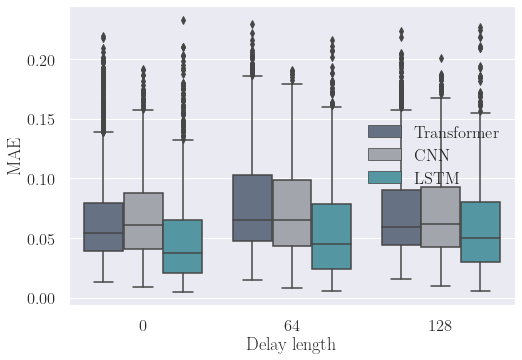

In [11]:
sns.boxplot(x="d", y="mae", hue="model", data=predictions, palette=palette_bp)
plt.ylabel("MAE")
delays = predictions["d"].unique()
plt.xticks(ticks=np.arange(len(delays)), labels=[int(x) for x in delays])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Delay length")
plt.legend().title = None # disables legend title which is 'model'
plt.savefig(base_dir_notebook + "/figures/mae_different_delays.pdf")

# Visualize distribution of mae for different frequencies

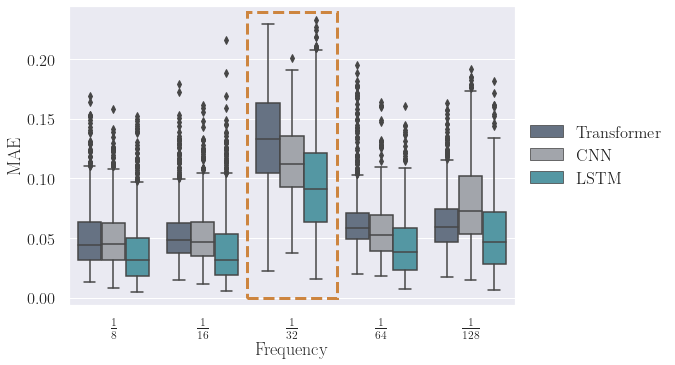

In [12]:
ax = sns.boxplot(x="f", y="mae", hue="model", data=predictions, palette=palette_bp)
plt.ylabel("MAE")
freqs = predictions["f"].unique()
nice_labels = {1/128:r"$\frac{1}{128}$", 1/64:r"$\frac{1}{64}$", 1/32:r"$\frac{1}{32}$", 1/16:r"$\frac{1}{16}$", 1/8:r"$\frac{1}{8}$"}
rect = patches.Rectangle((1.5, 0), 1, 0.24, linewidth=3, edgecolor="peru", linestyle="--", facecolor='none')
ax.add_patch(rect)
plt.xticks(ticks=np.arange(len(freqs)), labels=[nice_labels[f] for f in freqs])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
plt.xlabel("Frequency")
plt.savefig(base_dir_notebook + "/figures/mae_different_frequencies.pdf", bbox_inches="tight")

## Mean performance of generalized frequency
Used for comparison with mean estimator, only for lstm because I reference it in my thesis

In [13]:
predictions[(predictions["f"] == 1/32) & (predictions["model"] == "LSTM")]["mae"].mean()


0.09576024115085602

# Visualize distribution of mae for different sigmas

2021-11-11 00:11:00 Mischa-PC src.visualization[1380] INFO using latex font


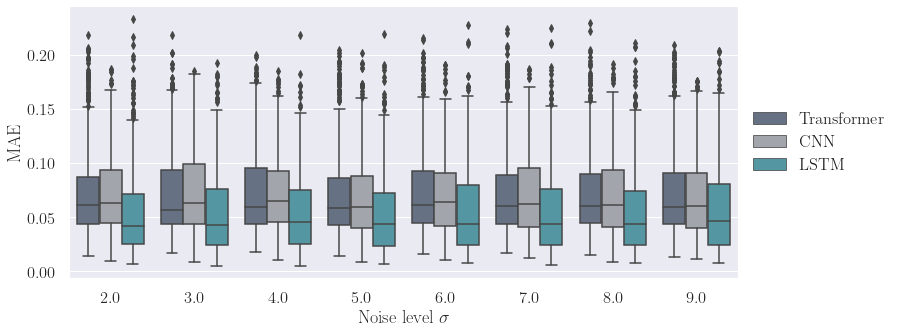

In [14]:
from src.visualization.visualize import Visualization
viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1, figsize=(12, 5))
sns.boxplot(x="s", y="mae", hue="model", data=predictions, palette=palette_bp)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
plt.ylabel("MAE")
plt.xlabel("Noise level $\sigma$")
plt.savefig(base_dir_notebook + "/figures/mae_different_noise_levels.pdf", bbox_inches="tight")

2021-11-11 00:11:01 Mischa-PC src.visualization[1380] INFO using latex font


<Figure size 576x396 with 0 Axes>

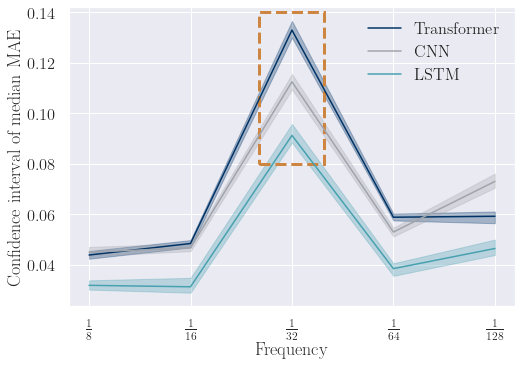

In [15]:
from src.visualization.visualize import ConfidenceIntervalVisualization

plt.clf()
predictions_w_o_generalization = predictions
viz = ConfidenceIntervalVisualization(use_latex_font=True, font_scale=1.5)
viz.subplots(1, 1)
viz.plot(predictions=predictions_w_o_generalization, characteristic="f", xlabel="Frequency", ylabel="Confidence interval of median MAE", colors=palette, verbose=False, plot_only_median=False)
plt.xscale("log")
nice_labels = {1/128:r"$\frac{1}{128}$", 1/64:r"$\frac{1}{64}$",1/32:r"$\frac{1}{32}$", 1/16:r"$\frac{1}{16}$", 1/8:r"$\frac{1}{8}$"}
plt.xticks(ticks=[1/8, 1/16, 1/32, 1/64, 1/128])
viz.get_ax(0).xaxis.set_ticklabels([nice_labels[f] for f in nice_labels.keys()])

# add generalization patch
rect = patches.Rectangle((1/40, 0.08), 0.014, 0.06, linewidth=3, edgecolor="peru", linestyle="--", facecolor='none')
viz.get_ax(0).add_patch(rect)

#xticks = predictions["s"].unique()
#plt.xticks(xticks, labels=[int(xt) for xt in xticks])
plt.legend()
plt.savefig(base_dir_notebook + "/figures/confidence_intervals_frequency.pdf")
plt.show()

# Visualize distribution of mae for different sequence lengths

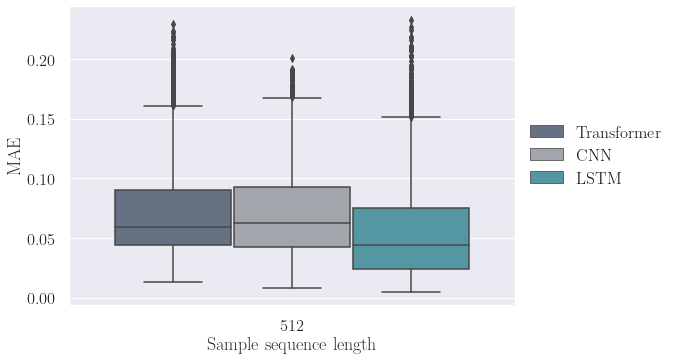

In [16]:
sns.boxplot(x="l", y="mae", hue="model", data=predictions, palette=palette_bp)
plt.ylabel("MAE")
seq_lens = predictions["l"].unique()
plt.xticks(ticks=np.arange(len(seq_lens)), labels=[int(x) for x in seq_lens])
plt.xlabel("Sample sequence length")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
plt.savefig(base_dir_notebook + "/figures/mae_different_seqlens.pdf")

# Visualize distribution of MAEs for different delay lengths

## Different delays on all frequencies

2021-11-11 00:11:03 Mischa-PC src.visualization[1380] INFO using latex font


Transformer:
f:   0 lower: 0.048 - median: 0.049 - upper: 0.050
f:  64 lower: 0.056 - median: 0.058 - upper: 0.059
f: 128 lower: 0.052 - median: 0.053 - upper: 0.054
CNN:
f:   0 lower: 0.050 - median: 0.052 - upper: 0.054
f:  64 lower: 0.053 - median: 0.055 - upper: 0.057
f: 128 lower: 0.051 - median: 0.053 - upper: 0.055
LSTM:
f:   0 lower: 0.029 - median: 0.031 - upper: 0.033
f:  64 lower: 0.034 - median: 0.036 - upper: 0.039
f: 128 lower: 0.039 - median: 0.041 - upper: 0.044


<Figure size 576x396 with 0 Axes>

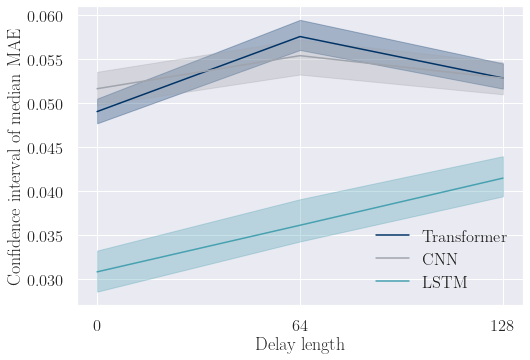

In [17]:
from src.visualization.visualize import ConfidenceIntervalVisualization
preds_non_gen = predictions[predictions["f"].isin([1/8, 1/16, 1/64, 1/128])]

plt.clf()
viz = ConfidenceIntervalVisualization(use_latex_font=True, font_scale=1.5)
viz.subplots(1, 1)
viz.plot(predictions=preds_non_gen, characteristic="d", xlabel="Delay length", ylabel="Confidence interval of median MAE", colors=palette, verbose=True, plot_only_median=False)
plt.legend()
xticks = preds_non_gen["d"].unique()
plt.xticks(xticks, labels=[int(xt) for xt in xticks])
plt.savefig(base_dir_notebook + "/figures/confidence_intervals_delays.pdf")
plt.show()


Nothing interesting here. Delay 0 is easier than Delay 64 due to data ambiguity. Last delay only worse for lstm,
but I expect this to be related to the significant gap between the performances + last delay length has highest
percentage of noise in signal. Maybe more different delays could show something interesting here.

## Bin amplitudes into categories to visualize performance change of different amplitudes

In [18]:
bin_boundaries = np.linspace(-60, 60, 13)
bins = np.linspace(-55, 55, 12)
for i in range(len(bin_boundaries) - 1):
    predictions.loc[(predictions["a1"] >= bin_boundaries[i]) & (predictions["a1"] < bin_boundaries[i + 1]), "a1_bin"] = bins[i]
    predictions.loc[(predictions["a2"] >= bin_boundaries[i]) & (predictions["a2"] < bin_boundaries[i + 1]), "a2_bin"] = bins[i]
predictions.loc[predictions["a1"] == 60, "a1_bin"] = bins[-1]
predictions.loc[predictions["a2"] == 60, "a2_bin"] = bins[-1]


2021-11-11 00:11:03 Mischa-PC src.visualization[1380] INFO using latex font


Transformer:
f: -55 lower: 0.107 - median: 0.142 - upper: 0.186
f: -45 lower: 0.057 - median: 0.065 - upper: 0.146
f: -35 lower: 0.053 - median: 0.075 - upper: 0.136
f: -25 lower: 0.056 - median: 0.070 - upper: 0.110
f: -15 lower: 0.071 - median: 0.086 - upper: 0.114
f:  -5 lower: 0.079 - median: 0.089 - upper: 0.109
f:   5 lower: 0.077 - median: 0.085 - upper: 0.094
f:  15 lower: 0.075 - median: 0.084 - upper: 0.145
f:  25 lower: 0.066 - median: 0.071 - upper: 0.089
f:  35 lower: 0.054 - median: 0.060 - upper: 0.083
f:  45 lower: 0.067 - median: 0.077 - upper: 0.088
f:  55 lower: 0.073 - median: 0.077 - upper: 0.087
CNN:
f: -55 lower: 0.107 - median: 0.164 - upper: 0.176
f: -45 lower: 0.051 - median: 0.097 - upper: 0.156
f: -35 lower: 0.055 - median: 0.096 - upper: 0.144
f: -25 lower: 0.060 - median: 0.085 - upper: 0.124
f: -15 lower: 0.072 - median: 0.094 - upper: 0.116
f:  -5 lower: 0.085 - median: 0.091 - upper: 0.103
f:   5 lower: 0.076 - median: 0.084 - upper: 0.091
f:  15 lower:

<Figure size 576x396 with 0 Axes>

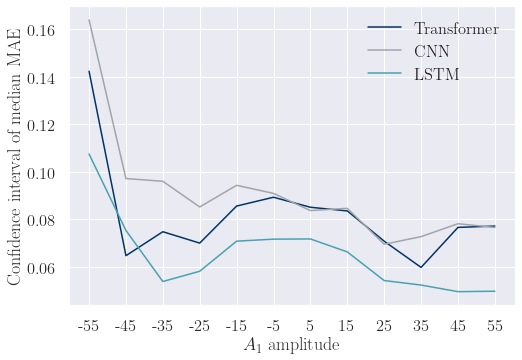

In [19]:
from src.visualization.visualize import ConfidenceIntervalVisualization

plt.clf()
viz = ConfidenceIntervalVisualization(use_latex_font=True, font_scale=1.5)
viz.subplots(1, 1)
filtered_predictions = predictions[predictions["a2_bin"] == -55]
viz.plot(predictions=filtered_predictions, characteristic="a1_bin", xlabel="$A_1$ amplitude", ylabel="Confidence interval of median MAE", colors=palette, verbose=True, plot_only_median=True)
plt.legend()
xticks = filtered_predictions["a1_bin"].unique()
plt.xticks(xticks, labels=[int(xt) for xt in xticks])
plt.savefig(base_dir_notebook + "/figures/confidence_intervals_ampltidues_a2_minus55.pdf")
plt.show()


# Visualize distribution of amplitude

2021-11-11 00:11:04 Mischa-PC src.visualization[1380] INFO using latex font


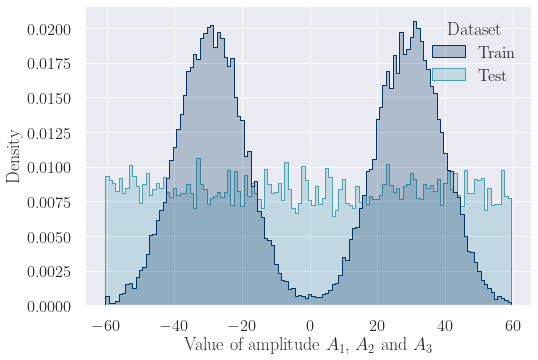

In [20]:
train_amplitudes = trained_models["transformer"]["model"].train_dataset._amplitudes[:,:3].reshape(-1) # same as model cnn and lstm
test_amplitudes = test_dataloader.dataset._amplitudes[:,:3].reshape(-1)
dataset_indicator = np.zeros(len(train_amplitudes) + len(test_amplitudes))
dataset_indicator[len(train_amplitudes):] = 1
amplitude_df = pd.DataFrame({'amplitude':np.concatenate((train_amplitudes, test_amplitudes)), 'Dataset': ["Train"] * len(train_amplitudes) + ["Test"]* len(test_amplitudes)})
bins=np.arange(train_amplitudes.min(), train_amplitudes.max()+1)-0.5

viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1)
sns.histplot(ax=axs[0, 0], data=amplitude_df, x="amplitude", hue="Dataset", palette=[palette[0], palette[2]], bins=bins, element='step', stat="density", common_norm=False)
plt.xlabel("Value of amplitude $A_1$, $A_2$ and $A_3$")
plt.legend
plt.savefig(base_dir_notebook + "/figures/train_test_data_distribution.pdf")
plt.show()


# Visualize Difference of model performance depending on the Delay Length

2021-11-11 00:11:06 Mischa-PC src.visualization[1380] INFO using latex font


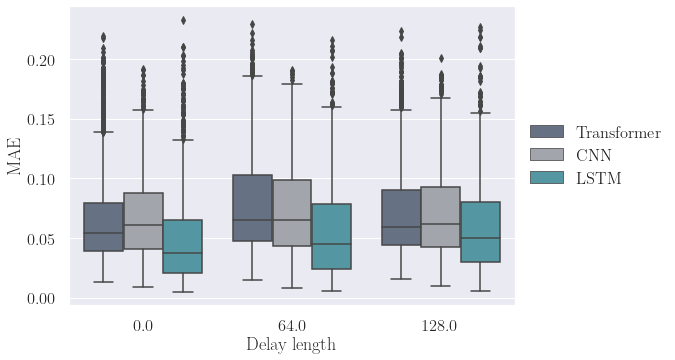

In [21]:
viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1)
sns.boxplot(x="d", y="mae", hue="model", data=predictions, palette=palette_bp)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
plt.ylabel("MAE")
plt.xlabel("Delay length")
plt.savefig(base_dir_notebook + "/figures/mae_different_delays_all_models.pdf")


## Visualize the accuracy depending on the amplitude

2021-11-11 00:11:06 Mischa-PC src.visualization[1380] INFO using latex font


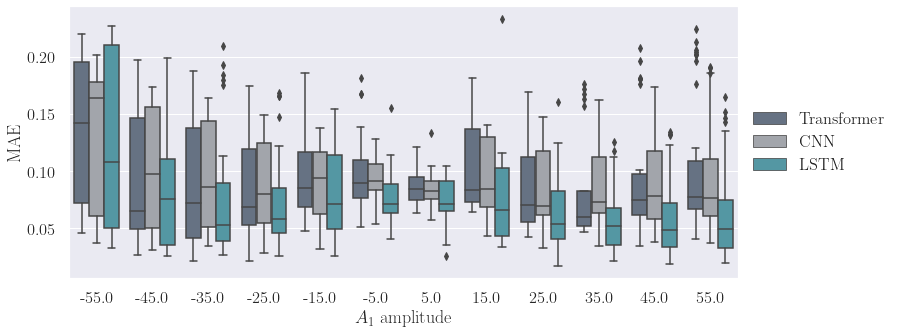

In [22]:
viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1, figsize=(12, 5))
sns.boxplot(x="a1_bin", y="mae", hue="model", data=predictions[predictions["a2_bin"] == -55], palette=palette_bp)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
plt.ylabel("MAE")
plt.xlabel("$A_1$ amplitude")
plt.savefig(base_dir_notebook + "/figures/mae_different_a1_bins_a2_bin_minus55.pdf")


## Visualize mean in 2d depending on the amplitudes

In [23]:
#model = "Transformer"
model = "Transformer"

a1_bins = sorted(predictions["a1_bin"].unique())
a2_bins = sorted(predictions["a2_bin"].unique())
means_trafo = np.zeros((len(a1_bins), len(a2_bins)))
means_cnn = np.zeros((len(a1_bins), len(a2_bins)))
means_lstm = np.zeros((len(a1_bins), len(a2_bins)))
for i, a1 in enumerate(a1_bins):
    for j, a2 in enumerate(a2_bins):
        means_trafo[i, j] = predictions[(predictions["a1_bin"] == a1) & (predictions["a2_bin"] == a2) & (predictions["model"] == "Transformer")]["mae"].mean()
        means_cnn[i, j] = predictions[(predictions["a1_bin"] == a1) & (predictions["a2_bin"] == a2) & (predictions["model"] == "CNN")]["mae"].mean()
        means_lstm[i, j] = predictions[(predictions["a1_bin"] == a1) & (predictions["a2_bin"] == a2) & (predictions["model"] == "LSTM")]["mae"].mean()

means_min = min(means_trafo.min(), means_lstm.min(), means_cnn.min())
means_max = min(means_trafo.max(), means_lstm.max(), means_cnn.max())

2021-11-11 00:11:08 Mischa-PC src.visualization[1380] INFO using latex font


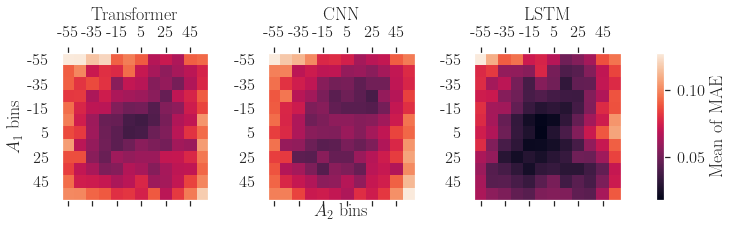

In [24]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize
#https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axes = viz.subplots(1, 3, figsize=(11,  3))
fig.tight_layout(pad=1.0)
normalizer=Normalize(means_min, means_max)
im=cm.ScalarMappable(norm=normalizer)
ims = []
for i, means in enumerate([means_trafo, means_cnn, means_lstm]):
    ax = viz.get_ax(i)
    ims.append(ax.matshow(means, norm=normalizer))
    ax.grid(False)
    ax.set_title(model_names[i])
    ax.set_xticks(np.arange(len(a2_bins))[::2])
    ax.set_yticks(np.arange(len(a1_bins))[::2])
    ax.set_xticklabels(np.array(a2_bins, dtype=int)[::2])
    ax.set_yticklabels(np.array(a1_bins, dtype=int)[::2])

viz.get_ax(0).set_ylabel("$A_1$ bins")
viz.get_ax(1).set_xlabel("$A_2$ bins")

fig.colorbar(im, ax=axes.ravel().tolist(), label="Mean of MAE")
plt.savefig(base_dir_notebook + "/figures/mae_amplitudes_all_models_matshow.pdf", bbox_inches="tight")
plt.show()


# Look at some of the best / worst predictions of Transformer

## Start with worst predictions

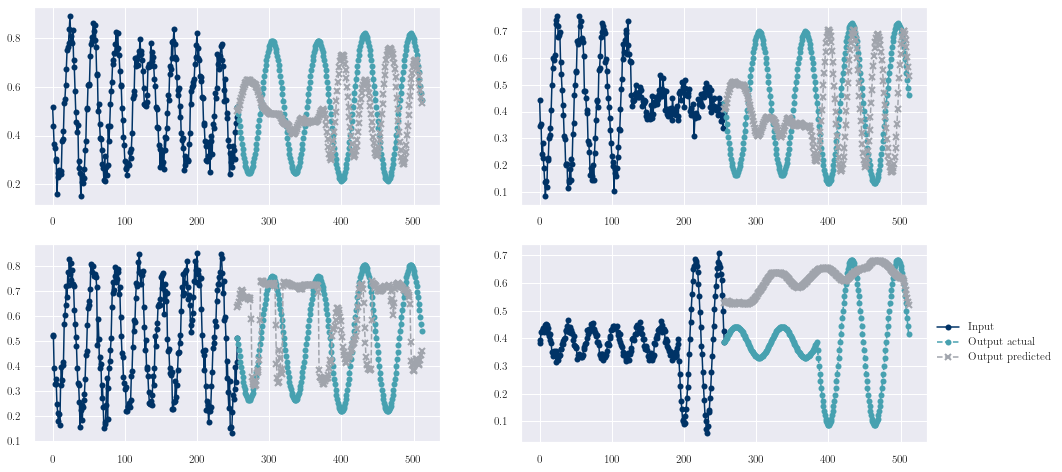

In [25]:
from src.visualization.visualize import ModelPredictionVisualization
transformer_outputs = np.array(tf_trainer.lightning_module.output_predictions)
cnn_outputs = np.array(cnn_trainer.lightning_module.output_predictions)
lstm_outputs  = np.array(lstm_trainer.lightning_module.output_predictions)
outputs = {"CNN": cnn_outputs,
           "Transformer": transformer_outputs,
           "LSTM":lstm_outputs}


viz_num = 4
# get the worst samples with delay length 48 and visualize them
samples = predictions.sort_values(by="mae")

best_samples = samples[:viz_num]
median_samples = samples[(len(samples) // 2):(len(samples) // 2 + viz_num)]
worst_samples = samples[-viz_num:]

# ground truth
worst_x, worst_y, _ = test_dataloader.dataset[worst_samples["sample_idx"]]
median_x, median_y, _ = test_dataloader.dataset[median_samples["sample_idx"]]
best_x, best_y, _ = test_dataloader.dataset[best_samples["sample_idx"]]

# predicted
out_preds = []
pred_start = len(worst_x[0])
for idx, model in zip(worst_samples["sample_idx"], worst_samples["model"]):
    out_preds.append(outputs[model][idx])

# Visualize
use_latex_font = False
viz = ModelPredictionVisualization(use_latex_font=False)
viz.subplots(nrows=viz_num // 2, ncols=2, figsize=(16, 8))
viz.plot(worst_x, worst_y, out_preds, pred_starts=[pred_start, ] * viz_num)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
viz.save(filename=base_dir_notebook+ "/figures/worst_samples.pdf")
viz.plt.show()

# Median Predictions

           mae        model      d      l    s       f    a1    a2
56    0.055566  Transformer   64.0  512.0  2.0  0.1250 -49.0  38.0
190   0.055590          CNN  128.0  512.0  2.0  0.0625 -30.0 -31.0
1552  0.055595         LSTM  128.0  512.0  5.0  0.1250  23.0 -58.0
3142  0.055597  Transformer  128.0  512.0  8.0  0.0625 -23.0 -39.0


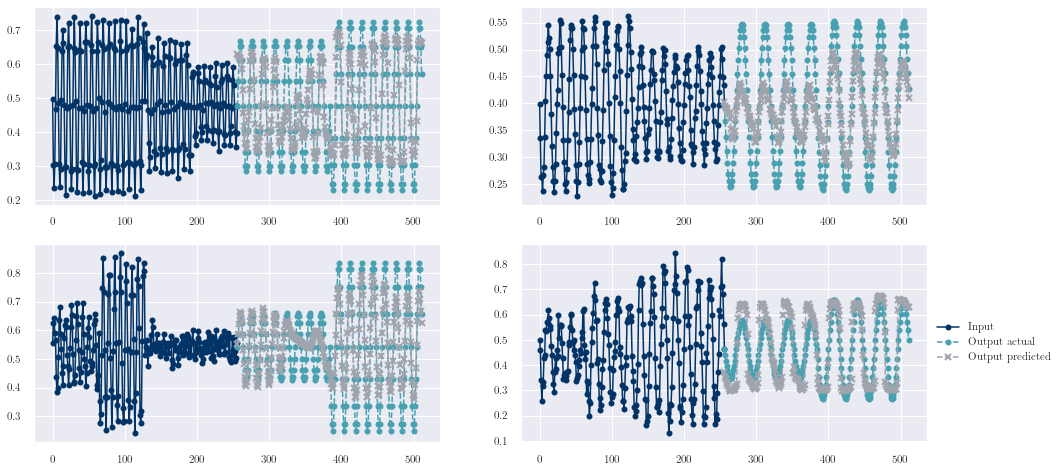

In [26]:
out_preds = []

print(median_samples[["mae", "model", "d","l","s","f","a1","a2"]])
for idx, model in zip(median_samples["sample_idx"], median_samples["model"]):
    out_preds.append(outputs[model][idx])

# Visualize
use_latex_font = False
viz = ModelPredictionVisualization(use_latex_font=False)
viz.subplots(nrows=viz_num // 2, ncols=2, figsize=(16, 8))
viz.plot(median_x, median_y, out_preds, pred_starts=[pred_start, ] * viz_num)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
viz.save(filename=base_dir_notebook+ "/figures/median_samples.pdf")
viz.plt.show()

## Best predictions

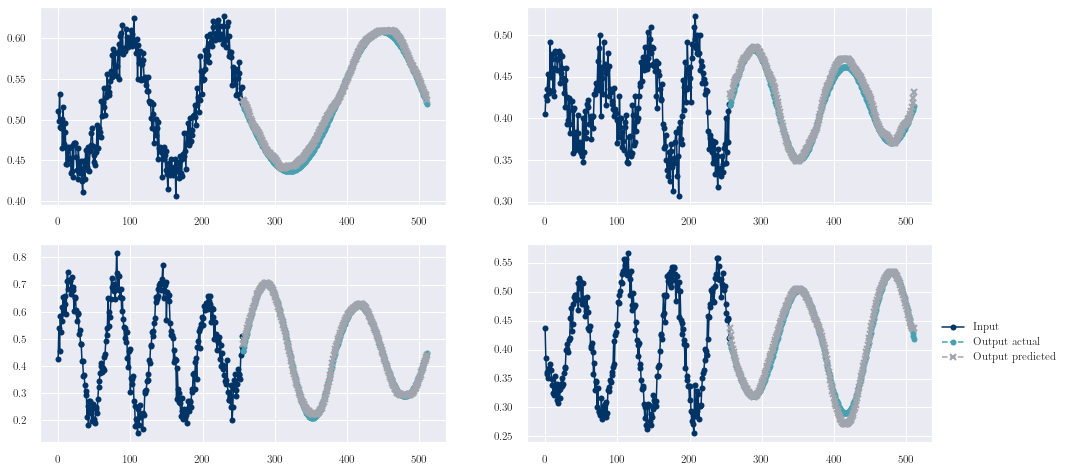

In [27]:
out_preds = []

for idx, model in zip(best_samples["sample_idx"], best_samples["model"]):
    out_preds.append(outputs[model][idx])

trafo_out_pred = cnn_outputs[best_samples["sample_idx"]]
# Visualize
use_latex_font = False
viz = ModelPredictionVisualization(use_latex_font=False)
viz.subplots(nrows=viz_num // 2, ncols=2, figsize=(16, 8))
viz.plot(best_x, best_y, out_preds, pred_starts=[pred_start, ] * viz_num)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
viz.save(filename=base_dir_notebook+ "/figures/worst_samples.pdf")
viz.plt.show()


## Best prediction with generalized frequency

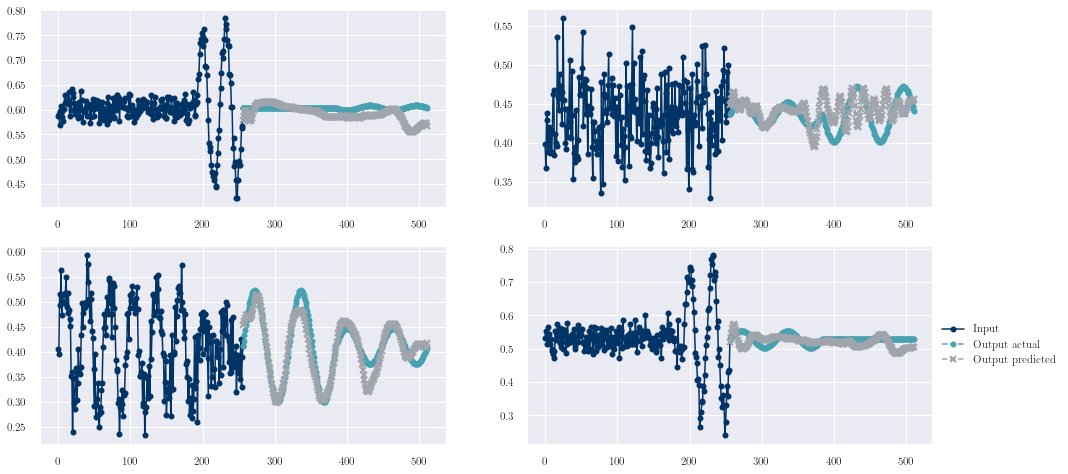

In [28]:
viz_num = 4
preds = predictions[predictions["f"] == 1/32]
samples = preds.sort_values(by="mae")

best_samples = samples[:viz_num]

# ground truth
best_x, best_y, _ = test_dataloader.dataset[best_samples["sample_idx"]]

# predicted
out_preds = []
pred_start = len(best_x[0])

for idx, model in zip(best_samples["sample_idx"], best_samples["model"]):
    out_preds.append(outputs[model][idx])

use_latex_font = False
viz = ModelPredictionVisualization(use_latex_font=False)
viz.subplots(nrows=viz_num // 2, ncols=2, figsize=(16, 8))
viz.plot(best_x, best_y, out_preds, pred_starts=[pred_start, ] * viz_num)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
viz.save(filename=base_dir_notebook+ "/figures/best_samples_missing_frequency.pdf")
viz.plt.show()


# Best prediction of generalization frequencies seperated by amplitude

2021-11-11 00:11:16 Mischa-PC src.visualization[1380] INFO using latex font


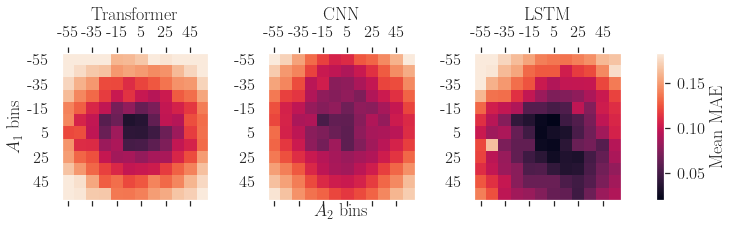

In [29]:
preds = predictions[predictions["f"] == 1/32]
a1_bins = sorted(predictions["a1_bin"].unique())
a2_bins = sorted(predictions["a2_bin"].unique())
means_trafo = np.zeros((len(a1_bins), len(a2_bins)))
means_cnn = np.zeros((len(a1_bins), len(a2_bins)))
means_lstm = np.zeros((len(a1_bins), len(a2_bins)))
for i, a1 in enumerate(a1_bins):
    for j, a2 in enumerate(a2_bins):
        means_trafo[i, j] = preds[(preds["a1_bin"] == a1) & (preds["a2_bin"] == a2) & (preds["model"] == "Transformer")]["mae"].mean()
        means_cnn[i, j] = preds[(preds["a1_bin"] == a1) & (preds["a2_bin"] == a2) & (preds["model"] == "CNN")]["mae"].mean()
        means_lstm[i, j] = preds[(preds["a1_bin"] == a1) & (preds["a2_bin"] == a2) & (preds["model"] == "LSTM")]["mae"].mean()

means_min = min(means_trafo.min(), means_lstm.min(), means_cnn.min())
means_max = min(means_trafo.max(), means_lstm.max(), means_cnn.max())

viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axes = viz.subplots(1, 3, figsize=(11,  3))
fig.tight_layout(pad=1.0)
normalizer=Normalize(means_min, means_max)
im=cm.ScalarMappable(norm=normalizer)
ims = []
for i, means in enumerate([means_trafo, means_cnn, means_lstm]):
    ax = viz.get_ax(i)
    ims.append(ax.matshow(means, norm=normalizer))
    ax.grid(False)
    ax.set_title(model_names[i])
    ax.set_xticks(np.arange(len(a2_bins))[::2])
    ax.set_yticks(np.arange(len(a1_bins))[::2])
    ax.set_xticklabels(np.array(a2_bins, dtype=int)[::2])
    ax.set_yticklabels(np.array(a1_bins, dtype=int)[::2])

viz.get_ax(0).set_ylabel("$A_1$ bins")
viz.get_ax(1).set_xlabel("$A_2$ bins")

fig.colorbar(im, ax=axes.ravel().tolist(), label="Mean MAE")
plt.savefig(base_dir_notebook + "/figures/mae_amplitudes_all_models_matshow_only_generalized_frequency.pdf", bbox_inches="tight")
plt.show()

# visualize by mean

2021-11-11 00:11:18 Mischa-PC src.visualization[1380] INFO using latex font


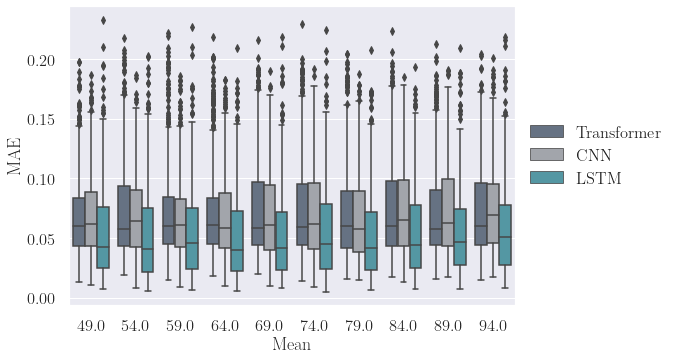

In [30]:
sorted(predictions["mean"].unique())

bin_boundaries = np.linspace(47, 97, 11)
bins = np.linspace(49, 94, 10)
for i in range(len(bin_boundaries) - 1):
    predictions.loc[(predictions["mean"] >= bin_boundaries[i]) & (predictions["mean"] < bin_boundaries[i + 1]), "mean_bin"] = bins[i]

viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1)
sns.boxplot(x="mean_bin", y="mae", hue="model", data=predictions, palette=palette_bp)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
plt.ylabel("MAE")
plt.xlabel("Mean")
plt.savefig(base_dir_notebook + "/figures/mae_different_mean_bins.pdf")


## Analyze Generalization Capabilities by looking at missing frequency
Not that interesting. Maybe beccause of the data. Model can learn the first amplitude from the first
highest value independant of delay length. The second one I am not so sure about...

2021-11-11 00:11:19 Mischa-PC src.visualization[1380] INFO using latex font


[0.125     0.0625    0.03125   0.015625  0.0078125]


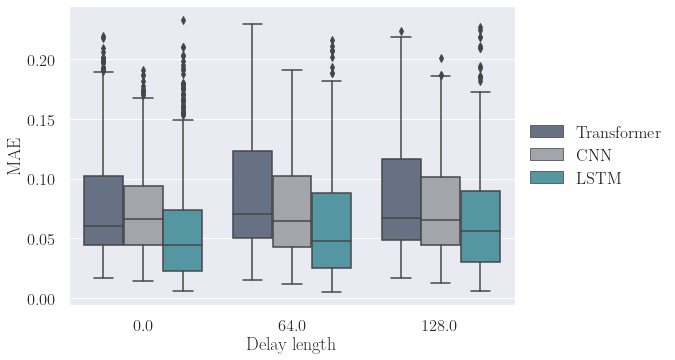

In [31]:
print(predictions["f"].unique())
viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1)
sns.boxplot(x="d", y="mae", hue="model", data=predictions[predictions["f"].isin([1/16, 1/32, 1/64])], palette=palette_bp)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model"
plt.ylabel("MAE")
plt.xlabel("Delay length")
plt.savefig(base_dir_notebook + "/figures/mae_different_delays_all_models_generalization_only.pdf")

# Analyzing Optuna Studies

## Visualize all model performances

2021-11-11 00:11:20 Mischa-PC src.visualization[1380] INFO using latex font
2021-11-11 00:11:20 Mischa-PC matplotlib.legend[1380] WARNING No handles with labels found to put in legend.


<Figure size 576x396 with 0 Axes>

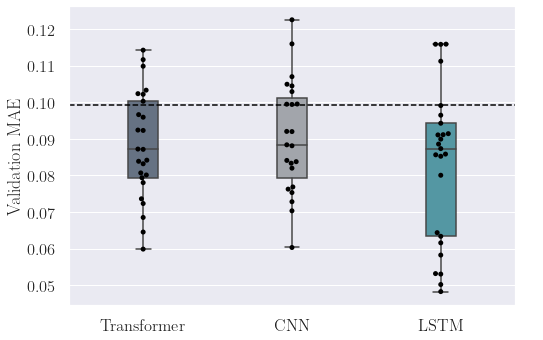

In [32]:
cnn_study_path = f"./models/{experiment_name}/cnn"
lstm_study_path = f"./models/{experiment_name}/lstm"
transformer_study_path= f"./models/{experiment_name}/transformer"

# load study summary (created by hyperparameter_tuning.py)
studies = {"cnn": cnn_study_path, "lstm": lstm_study_path, "transformer":transformer_study_path}
summaries = {}
models = {}
for model, path in studies.items():
    with open(os.path.join(path, "study_summary.yaml"), "r") as inp:
        try:
            summary = yaml.load(inp, Loader=yaml.BaseLoader)
        except yaml.YAMLError as e:
            print(e)
    summaries[model] = summary

MODEL_TO_MODEL_NAME = {"cnn": "CNN", "lstm":"LSTM", "transformer":"Transformer"}
train_values = []
for model in summaries.keys():
    storage = summaries[model]["storage_name"]
    study = optuna.load_study(study_name=summaries[model]["study_name"], storage=storage)
    for trial in study.trials:
        train_values.append({"train_value":trial.value, "model":MODEL_TO_MODEL_NAME[model]})


train_values = pd.DataFrame(train_values)

plt.clf()
viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1)
sns.boxplot(x="model", y="train_value", order=["Transformer", "CNN", "LSTM"], data=train_values, palette=palette_bp, width=0.2)
sns.swarmplot(x="model", y="train_value", order=["Transformer", "CNN", "LSTM"], data=train_values, color="0")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)).title = "Model" # disables legend title which is 'model'
viz.get_ax(0).axhline(mean_predictor_mae, c="black", ls='--')
plt.ylabel("Validation MAE")
plt.xlabel("")
plt.savefig(base_dir_notebook + "/figures/validation_all_trials.pdf")

## Training time visualization

2021-11-11 00:11:21 Mischa-PC src.visualization[1380] INFO using latex font


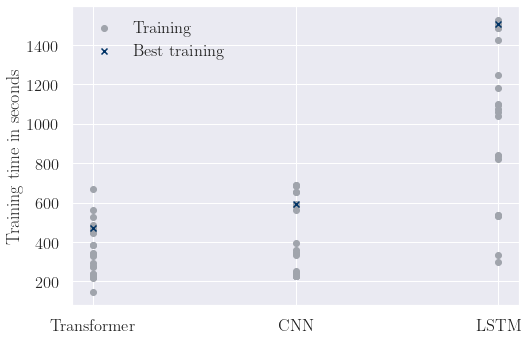

In [33]:
import optuna
from src.visualization.utils import FAU_BLUE, FAU_GREY

train_times = []
for model in ["transformer", "cnn", "lstm"]:
    storage = summaries[model]["storage_name"]
    study = optuna.load_study(study_name=summaries[model]["study_name"], storage=storage)
    for trial in study.trials:
        train_length = (trial.datetime_complete - trial.datetime_start).total_seconds()
        train_times.append({"train_length":train_length, "model":MODEL_TO_MODEL_NAME[model], "best":trial.number == study.best_trial.number})
train_times = pd.DataFrame(train_times)
best_times = train_times[train_times["best"] == True]

viz = Visualization(use_latex_font=True, font_scale=1.5)
fig, axs = viz.subplots(1, 1)
plt.scatter(train_times["model"], train_times["train_length"], color=FAU_GREY, marker='o', label="Training")
plt.scatter(best_times["model"], best_times["train_length"], color=FAU_BLUE, marker='x', label="Best training")
plt.ylabel("Training time in seconds")
plt.legend()
plt.savefig(base_dir_notebook + "/figures/training_times.pdf")

## Inference time visualization

In [34]:
plt.tight_layout(False)
n_runs = 5
viz = InferenceTimeVisualization(use_latex_font=True, font_scale=1.5)
viz.do_inference(n_runs=n_runs,
                 cnn_model=trained_models["cnn"]["model"],
                 cnn_trainer=cnn_trainer,
                 lstm_model=trained_models["lstm"]["model"],
                 lstm_trainer=lstm_trainer,
                 trafo_model=trained_models["transformer"]["model"],
                 trafo_trainer=tf_trainer,
                 dataloader=test_dataloader)

C:\Users\Mischa\AppData\Local\Temp/ipykernel_1380/1890664436.py:1: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  plt.tight_layout(False)
2021-11-11 00:11:22 Mischa-PC src.visualization[1380] INFO using latex font
C:\Users\Mischa\Anaconda3\envs\mtenv\lib\site-packages\pytorch_lightning\trainer\trainer.py:678: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
2021-11-11 00:11:22 Mischa-PC pytorch_lightning.accelerators.gpu[1380] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Mischa\Anaconda3\envs\mtenv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wor

Testing: 0it [00:00, ?it/s]

2021-11-11 00:11:22 Mischa-PC pytorch_lightning.accelerators.gpu[1380] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:11:23 Mischa-PC pytorch_lightning.accelerators.gpu[1380] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:11:23 Mischa-PC pytorch_lightning.accelerators.gpu[1380] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:11:24 Mischa-PC pytorch_lightning.accelerators.gpu[1380] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:11:24 Mischa-PC pytorch_lightning.accelerators.gpu[1380] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:11:26 Mischa-PC pytorch_lightning.accelerators.gpu[1380] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:11:27 Mischa-PC pytorch_lightning.accelerators.gpu[1380] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:11:29 Mischa-PC pytorch_lightning.accelerators.gpu[1380] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:11:30 Mischa-PC pytorch_lightning.accelerators.gpu[1380] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:11:31 Mischa-PC pytorch_lightning.accelerators.gpu[1380] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:11:33 Mischa-PC pytorch_lightning.accelerators.gpu[1380] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:11:34 Mischa-PC pytorch_lightning.accelerators.gpu[1380] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:11:35 Mischa-PC pytorch_lightning.accelerators.gpu[1380] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

2021-11-11 00:11:36 Mischa-PC pytorch_lightning.accelerators.gpu[1380] INFO LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

<Figure size 576x396 with 0 Axes>

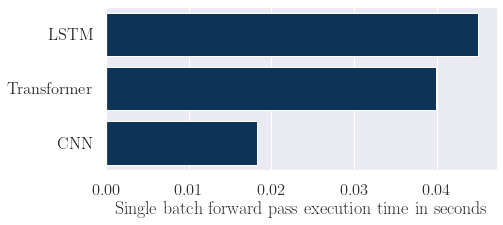

In [35]:
fig, axs = viz.subplots(1, 1, figsize=(7, 3))
viz.plot(axs[0, 0], palette=palette)
axs[0,0].set_xlabel("Single batch forward pass execution time in seconds")
axs[0,0].set_ylabel("")
plt.savefig(base_dir_notebook + f"/figures/single_batch_exec_{n_runs}_runs.pdf",bbox_inches="tight")

## Statistical tests

### Critical difference test on all different characteristics

In [36]:
#pred_2 = predictions[predictions["d"].isin([0, 16, 32, 64, 128])]
mean_prediction_by_model = predictions.groupby(["model", "d", "l", "s", "f"]).mean()
mean_prediction_by_model.head()
mean_prediction_by_model.reset_index(inplace=True) # resets multiindex

In [37]:
df_perf = mean_prediction_by_model[["model", "d", "l", "s", "f", "mae"]].rename(columns={"model":"classifier_name", "mae":"accuracy"})
df_perf["dataset_name"] = ""
# populate dataset_names that indicates the different characteritics
dataset_names = []
for i in range(len(df_perf)):
    entry = df_perf.iloc[i]
    dataset_names.append(f"delay_{int(entry['d'])}_fre_{str(entry['f'])[2:]}_sigma_{int(entry['s'])}_len_{int(entry['l'])}")
df_perf["dataset_name"] = dataset_names
df_perf = df_perf[["classifier_name", "accuracy", "dataset_name"]]
df_perf.head(3)

,classifier_name,accuracy,dataset_name
0,CNN,0.049861,delay_0_fre_0078125_sigma_2_len_512
1,CNN,0.047410,delay_0_fre_015625_sigma_2_len_512
2,CNN,0.121977,delay_0_fre_03125_sigma_2_len_512


['CNN' 'LSTM' 'Transformer']
CNN              1.0
LSTM           118.0
Transformer      1.0
dtype: float64
Transformer    2.566667
CNN            2.416667
LSTM           1.016667
dtype: float64
('LSTM', 'Transformer', 2.18067252180838e-21, True)
('CNN', 'LSTM', 2.3514195943537767e-21, True)
('CNN', 'Transformer', 0.036630598591254185, True)
Index(['Transformer', 'CNN', 'LSTM'], dtype='object')


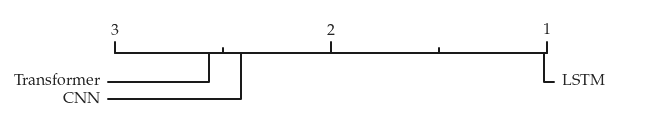

In [38]:
# reverse mae (for regression low values are good, for classification high values are good
df_perf["accuracy"] = df_perf["accuracy"].max() - df_perf["accuracy"]
from src.visualization.critical_difference import draw_cd_diagram
draw_cd_diagram(df_perf=df_perf, output_path=os.path.join(base_dir_notebook, f"figures/critical_difference_test_for_all_parameters.pdf"))


## List datasets where lstm was not best

In [39]:
# look at what datasets were not best by lstm
for index, ds in df_perf.iterrows():
    if ds["classifier_name"] != "LSTM":
        continue

    ds_name = ds["dataset_name"]
    trafo_performance = df_perf[(df_perf["dataset_name"] == ds_name) & (df_perf["classifier_name"] == "Transformer")]
    cnn_performance = df_perf[(df_perf["dataset_name"] == ds_name) & (df_perf["classifier_name"] == "CNN")]
    if ds["accuracy"] < max(float(trafo_performance["accuracy"]), float(cnn_performance["accuracy"])):
        print(f"Trafo: {trafo_performance['accuracy']}, CNN: {cnn_performance['accuracy']}, LSTM:{ds['accuracy']}")
        print(ds_name)

Trafo: 306    0.069889
Name: accuracy, dtype: float32, CNN: 66    0.078547
Name: accuracy, dtype: float32, LSTM:0.07421170920133591
delay_64_fre_015625_sigma_7_len_512
Trafo: 339    0.088542
Name: accuracy, dtype: float32, CNN: 99    0.066886
Name: accuracy, dtype: float32, LSTM:0.08688046038150787
delay_128_fre_125_sigma_5_len_512
